In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.optimize import curve_fit

# The following lines make plots in dark mode look reasonable.  If you are not using dark
# mode you don't need them, but you can also just leave them here, but you will need to set
# dark_mode = False

dark_mode = True
# plotting choices for dark-mode
if (dark_mode):
    from jupyterthemes import jtplot
    jtplot.style(theme='monokai', context='notebook', ticks=True, grid=False)
    linecolor = 'w'
else:
    linecolor = 'k'

# Fitting Data from an Experiment

The generic physics experiment goes as follows:  we measure some quantity, $y$, as a function of some other quantity, $x$.  We plot that data, and then we attempt to find a function, $y_{fit} = f(x)$ that best describes the data.  Typically, the function $f(x)$
will contain several parameters.  We seek to determine the values of these parameters (with uncertainties!) that give the best fit to the data, and then in turn we may be able to
extract interesting physics knowledge through the comparison of the parameter values to
either a theoretical prediction, or other measurments, or both.

In addition, in most (maybe all?) experiments, we have uncertainties,$\delta y$, associated with each data point.  We should understand more about how this affects the fitting procedure.

One of the oldest and still more relied upon methods for determining the optimal parameters of the fitting function is a method called "Ordinary Least Squares".  The basic theory behind this is as follows:

We first define a measure of the goodness of the fit:

$\chi^2 = \sum_i^N (\frac{y_i - y_{fit}(x_i)}{\delta y_i})^2$

Note that $y_{fit}(x_i)$ necessarily depends on some number of parameters, $(a,b,c,...)$. For example, for a linear fitting function, we have that:

$y_{fit}(x) = a x + b$

In order to make $\chi^2$ as small as possible, i.e. find its $minimum$ value, we must solve the set of equations defined by:

$\frac{\partial \chi^2}{\partial a} = 0, \frac{\partial \chi^2}{\partial b} = 0$

As it turns out, is the case of polynomial fitting functions (of any order, including linear), the values of the coefficients are uniquely defined.  That is, there is a single global minimum in the $\chi^2$ function.  For other non-linear fitting functions, there may be local minima in the $\chi^2$ function, and this requires that we provide initial starting values for the parameters of the fitting function that are close to the global minimum.

The procedure for finding the values of the parameters that minimize $\chi^2$, together with
the uncertainties in these parameters, is beyond the scope of this document.  We are going to make use of scipy's curve_fit algorithm, which calculates both the optimal
parameters (popt), along with a covariance matrix (pcov), which in turn can be used to
find the uncertainties in the parameters (perr).

In [2]:
# create some fake data

npts = 11
xlow = 0.5
xhigh = 5.5

xi = np.linspace(xlow,xhigh,npts)
yrandom = stats.norm.rvs(size=npts,loc=0,scale=.2) # Add some "noise" to the data

# The "equation" that we will fit is the line y=x.  Thus, we expect,
# in all cases, a slope of 1 and a y-intercept of 0.

yi = xi + yrandom

# For later .... generate the yi using an exponential function instead
#yi = 0.5*np.exp(0.48*xi)+ yrandom

# Create an array of uncertainties in y that increase with increasing x
xl = xlow + 0.1
sigmai = np.array([0.05 + 0.15*(xi[i]-xl) for i in range(npts)])

Text(0.5, 1.0, 'Fake Data with Increasing Uncertainties')

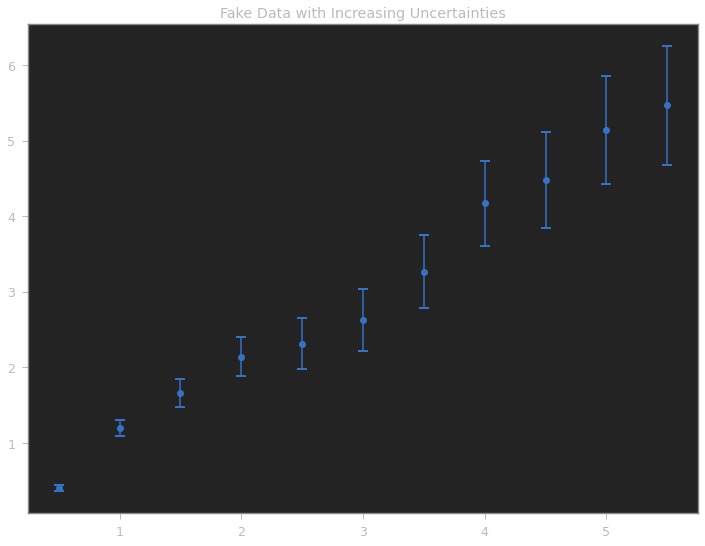

In [3]:
# Let's plot this data, just to see what it looks like

plt.rcParams["figure.figsize"] = (12,9)

figure, axis = plt.subplots(1, 1)
plot1 = plt.subplot2grid((1, 1), (0, 0), rowspan=1, colspan=1)

plot1.errorbar(xi, yi, yerr=sigmai, fmt='o', capsize=5, capthick=2)
plot1.set_title("Fake Data with Increasing Uncertainties")

## So, to fit this data using curve_fit, we need two things:

\begin{itemize}
\item A fitting function - which takes as input an array of the x-values of the dataset, and a pointer to an array of fit parameters. \\

\item A list of initial guesses for the fit parameters
\end{itemize}


In [4]:
def linearfitfunction(x,*paramlist):
    return paramlist[0]+paramlist[1]*x

init_vals = [0.0 for x in range(2)] # Note: choosing zero is fine here, since we have
                                    # a polynomial fit, and so the initial guesses don't
                                    # actually matter!

# Now, we are ready to call the curve_fit function
#
# It returns a list of the best fit parameters (popt), and the covariance matrix
# which is a (n x n) square matrix, where n is the number of fit parameters.  The
# diagonal elements of the covariance matrix can be used to calculate uncertainties
# in the parameters!

popt, pcov = curve_fit(linearfitfunction,xi,yi,p0=init_vals,sigma=sigmai)
perr = np.sqrt(np.diag(pcov))

For plotting purposes, let's do a neat thing to illustrate how the uncertainties in the
fit parameters lead to a "band" of uncertainty in the best fit curve.

The idea here is that we will create, randomly, a set of fit parameters, using
the covariance matrix as a constraint, many times (10000 times in this case).
'ps' will then be a 10000 x n 2D matrix, where n is the number of fit parameters.

Then, we create 10000 different fit lines (ysample), using these 10000 different sets
of fit parameters.

Finally, we choose upper and lower bounds, based on a 95% confidence interval.

Note:  if we wanted to create the usual (physics) error band, corresponding to +/- 1 sigma,
we would use 16.0 and 84.0 as the percentages (and we would get a narrower band).

Linear Fit: Coefficients (from curve_fit)
[-0.09585796  1.05325978]
Linear Fit: Covariance Matrix (from curve_fit)
[[ 0.00238665 -0.00204422]
 [-0.00204422  0.00299961]]

Linear Fit: Final Result: y = (1.05326 +/- 0.05477) x + (-0.09586 +/- 0.04885)



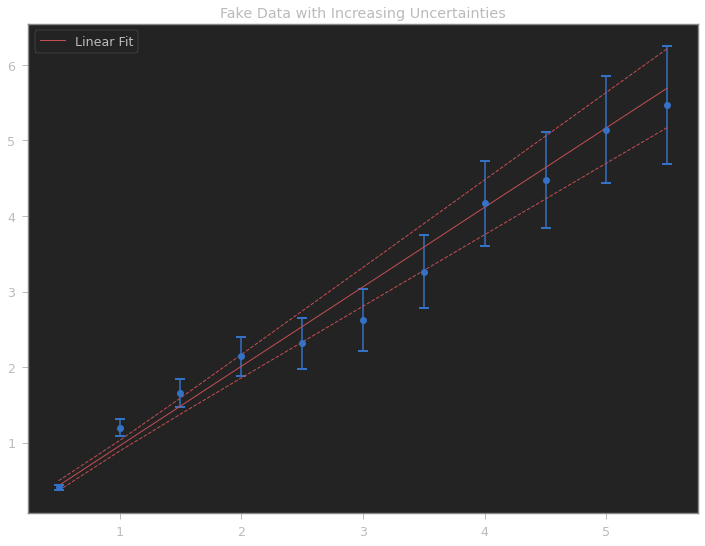

In [5]:
ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([linearfitfunction(xi,*pi) for pi in ps])

lower = np.percentile(ysample,2.5,axis=0)
upper = np.percentile(ysample,97.5,axis=0)
middle = (lower+upper)/2.0

print("Linear Fit: Coefficients (from curve_fit)")
print (popt)
print("Linear Fit: Covariance Matrix (from curve_fit)")
print (pcov)

print()
print ("Linear Fit: Final Result: y = (%0.5f +/- %0.5f) x + (%0.5f +/- %0.5f)" % (popt[1],perr[1],popt[0],perr[0]))
print()

plot1.plot(xi,middle,'r-',label="Linear Fit",linewidth=1)
plot1.plot(xi,lower,'r--',linewidth=1)
plot1.plot(xi,upper,'r--',linewidth=1)

plot1.legend()
figure

Trig Fit: Coefficients (from curve_fit)
[0.42829542 0.51903896]
Trig Fit: Covariance Matrix (from curve_fit)
[[ 0.00664749 -0.00375705]
 [-0.00375705  0.00345884]]

Trig Fit: Final Result: y = (0.42830 +/- 0.08153)exp((0.51904 +/- 0.05881)x)



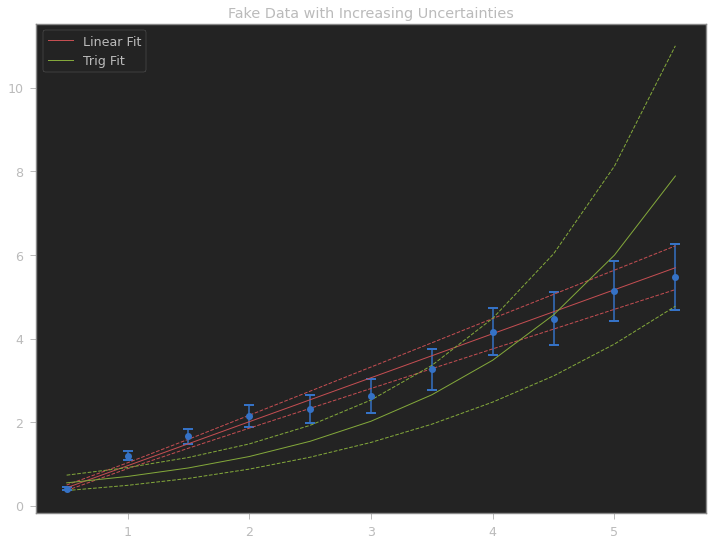

In [6]:
# Now, let's try fitting the data with a different fitting function:  an exponential function
#
# The rest of the code is almost exactly the same as above!

def expfitfunction(x,*paramlist):
    return paramlist[0]*np.exp(paramlist[1]*x)

init_vals2 = [0.5,0.48]

popt2, pcov2 = curve_fit(expfitfunction,xi,yi,p0=init_vals2,sigma=sigmai)
perr2 = np.sqrt(np.diag(pcov2))

ps2 = np.random.multivariate_normal(popt2,pcov2,10000)
ysample2=np.asarray([expfitfunction(xi,*pi2) for pi2 in ps2])

lower2 = np.percentile(ysample2,2.5,axis=0)
upper2 = np.percentile(ysample2,97.5,axis=0)
middle2 = (lower2+upper2)/2.0

print("Trig Fit: Coefficients (from curve_fit)")
print (popt2)
print("Trig Fit: Covariance Matrix (from curve_fit)")
print (pcov2)

print()
print ("Trig Fit: Final Result: y = (%0.5f +/- %0.5f)exp((%0.5f +/- %0.5f)x)" % (popt2[0],perr2[0],popt2[1],perr2[1]))
print()

plot1.plot(xi,middle2,'g-',label="Trig Fit",linewidth=1)
plot1.plot(xi,lower2,'g--',linewidth=1)
plot1.plot(xi,upper2,'g--',linewidth=1)

plot1.legend()
figure

Which is the better fit?  We should use our eyes as guidance, but we need a mathematical
measurement, right?

Since we are trying to minimize X^2, let's calculate it in each case.

In [7]:
def calc_chisquare(meas, sigma, fit): 
    diff = pow(meas-fit, 2.)
    test_statistic = (diff / pow(sigma,2.)).sum()
    return test_statistic

TS = calc_chisquare(yi, sigmai, linearfitfunction(xi, *popt))
NDF = len(yi) - len(popt)
print("Linear Fit: chisquare/NDF = {0:.2f} / {1:d}  = {2:.2f}".format(TS, NDF, TS / float(NDF)))

TS2 = calc_chisquare(yi, sigmai, expfitfunction(xi, *popt2))
NDF2 = len(yi) - len(popt2)
print("Exp Fit: chisquare/NDF = {0:.2f} / {1:d}  = {2:.2f}".format(TS2, NDF2, TS2 / float(NDF2)))


Linear Fit: chisquare/NDF = 8.69 / 9  = 0.97
Exp Fit: chisquare/NDF = 82.90 / 9  = 9.21


## Extrapolation and Interpolation

What if, after doing the fit(s), we wanted to know the value of y, from the fit, for a
given value of x, along with the uncertainty in that y value?

Note that we are using a 95% confidence interval here, which corresponds to about +/- 2*sigma


In [8]:

xpred = np.array([5.0])

ps = np.random.multivariate_normal(popt,pcov,10000)
ysample=np.asarray([linearfitfunction(xpred,*pi) for pi in ps])

lower = np.percentile(ysample,2.5,axis=0)
upper = np.percentile(ysample,97.5,axis=0)
middle = (lower+upper)/2.0

ypred = middle[0]
dypred = (upper[0]-lower[0])/2.0

print()
print ("Linear Fit @ x = %0.5f: y = (%0.5f +/- %0.5f)" % (xpred[0],ypred,dypred))
print()

ps2 = np.random.multivariate_normal(popt2,pcov2,10000)
ysample2=np.asarray([expfitfunction(xpred,*pi2) for pi2 in ps2])

lower2 = np.percentile(ysample2,2.5,axis=0)
upper2 = np.percentile(ysample2,97.5,axis=0)
middle2 = (lower2+upper2)/2.0

ypred2 = middle2[0]
dypred2 = (upper2[0]-lower2[0])/2.0

print()
print ("Exp Fit @ x = %0.5f: y = (%0.5f +/- %0.5f)" % (xpred[0],ypred2,dypred2))
print()


Linear Fit @ x = 5.00000: y = (5.16669 +/- 0.46425)


Exp Fit @ x = 5.00000: y = (6.00897 +/- 2.12082)

